In [15]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import re
from dateutil.relativedelta import relativedelta
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
import random
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle

pd.options.display.max_rows = 999
pd.options.display.max_columns = 500

## Carga de datos

In [2]:
mainpath = '/Users/nataliaurquiza/Documents/DS/Evaluacion_Kueski/archive/'

In [6]:
# Lectura de movie dataset
movie = pd.read_csv(os.path.join(mainpath,'movie.csv'))
print(movie.head())
print(movie.dtypes)
print(movie.shape)

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
movieId     int64
title      object
genres     object
dtype: object
(27278, 3)


In [7]:
# Para separar los géneros de cada película
movie_long = []
for obs in movie.itertuples():
    for genr in obs.genres.split('|'):
        movie_long.append([obs.movieId, obs.title, genr, 1])
movie_long = pd.DataFrame(movie_long, columns = ['movieId', 'title', 'genres', 'aux'])

movie = movie_long.pivot(index=['movieId', 'title'], columns='genres', values='aux').reset_index().fillna(0)

del(movie_long)

movie.head()

genres,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Extracción del año de la película

aux = []
pattern = re.compile(r"\((\d+)\)")
for item in movie.itertuples():
    #print(pattern.findall(item))
    if len(pattern.findall(item.title))>0:
        aux.append([int(pattern.findall(item.title)[-1])])
    else:
        aux.append([])
movie["anio_movie"] = pd.DataFrame(aux)[0]
del(aux)

movie.head()

genres,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,anio_movie
0,1,Toy Story (1995),0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0
1,2,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0
2,3,Grumpier Old Men (1995),0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1995.0
3,4,Waiting to Exhale (1995),0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1995.0
4,5,Father of the Bride Part II (1995),0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0


In [10]:
# Lectura de rating dataset

rating = pd.read_csv(os.path.join(mainpath,'rating.csv'))
rating['timestamp'] = pd.to_datetime(rating['timestamp'])
print(rating.head())
print(rating.dtypes)
print(rating.shape)

   userId  movieId  rating           timestamp
0       1        2     3.5 2005-04-02 23:53:47
1       1       29     3.5 2005-04-02 23:31:16
2       1       32     3.5 2005-04-02 23:33:39
3       1       47     3.5 2005-04-02 23:32:07
4       1       50     3.5 2005-04-02 23:29:40
userId                int64
movieId               int64
rating              float64
timestamp    datetime64[ns]
dtype: object
(20000263, 4)


In [11]:
# Revisando si un usuario califica una película varias veces
rating[rating.duplicated(['userId', 'movieId'])]

,userId,movieId,rating,timestamp


In [12]:
# Variable target
rating['y'] = np.where(rating['rating'] >= 4,
                           1,
                           0)
rating.head()

,userId,movieId,rating,timestamp,y
0,1,2,3.5,2005-04-02 23:53:47,0
1,1,29,3.5,2005-04-02 23:31:16,0
2,1,32,3.5,2005-04-02 23:33:39,0
3,1,47,3.5,2005-04-02 23:32:07,0
4,1,50,3.5,2005-04-02 23:29:40,0


<AxesSubplot:xlabel='timestamp,y'>

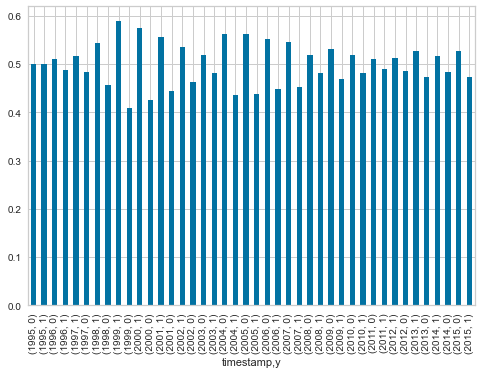

In [13]:
# Distribución de la target por año
rating.groupby(pd.DatetimeIndex(rating['timestamp']).year).y.value_counts(normalize = True).plot.bar()

In [14]:
# Cruce de rating con movie
movie_df = pd.merge(rating, movie, on='movieId')
del(rating)
movie_df.head()

,userId,movieId,rating,timestamp,y,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,anio_movie
0,1,2,3.5,2005-04-02 23:53:47,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0
1,5,2,3.0,1996-12-25 15:26:09,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0
2,13,2,3.0,1996-11-27 08:19:02,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0
3,29,2,3.0,1996-06-23 20:36:14,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0
4,34,2,3.0,1996-10-28 13:29:44,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0


In [15]:
# Antigüedad de la película al momento de la calificación
movie_df['antig_movie'] = pd.DatetimeIndex(movie_df['timestamp']).year - movie_df['anio_movie']

# Si la antigüedad de la película es menor a cero se define como cero
movie_df['antig_movie'] = np.where(movie_df['antig_movie']<0,
                                   0,
                                   movie_df['antig_movie'])
movie_df.head()

,userId,movieId,rating,timestamp,y,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,anio_movie,antig_movie
0,1,2,3.5,2005-04-02 23:53:47,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0,10.0
1,5,2,3.0,1996-12-25 15:26:09,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0,1.0
2,13,2,3.0,1996-11-27 08:19:02,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0,1.0
3,29,2,3.0,1996-06-23 20:36:14,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0,1.0
4,34,2,3.0,1996-10-28 13:29:44,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0,1.0


In [16]:
# Distribución de la target por género
cols_gen = ['Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western']
for gen in cols_gen:
    print(gen)
    print(movie_df.loc[(movie_df[gen] == 1)].y.value_counts(normalize = True))

Action
0    0.539802
1    0.460198
Name: y, dtype: float64
Adventure
0    0.515791
1    0.484209
Name: y, dtype: float64
Animation
1    0.530635
0    0.469365
Name: y, dtype: float64
Children
0    0.548008
1    0.451992
Name: y, dtype: float64
Comedy
0    0.541356
1    0.458644
Name: y, dtype: float64
Crime
1    0.559172
0    0.440828
Name: y, dtype: float64
Documentary
1    0.601319
0    0.398681
Name: y, dtype: float64
Drama
1    0.560114
0    0.439886
Name: y, dtype: float64
Fantasy
0    0.513058
1    0.486942
Name: y, dtype: float64
Film-Noir
1    0.696644
0    0.303356
Name: y, dtype: float64
Horror
0    0.589302
1    0.410698
Name: y, dtype: float64
IMAX
1    0.53422
0    0.46578
Name: y, dtype: float64
Musical
1    0.512425
0    0.487575
Name: y, dtype: float64
Mystery
1    0.556649
0    0.443351
Name: y, dtype: float64
Romance
1    0.503346
0    0.496654
Name: y, dtype: float64
Sci-Fi
0    0.537929
1    0.462071
Name: y, dtype: float64
Thriller
0    0.513725
1    0.486275
Name:

In [17]:
# Dataframe con todos los registros y variables de llave, timestamp, rating, y, anio_movie y antig_movie
movie_df.to_csv('movie_df.csv', index = False, quoting = 1, encoding = 'utf-8')

## Variables set 1: Del usuario hacia la película por género

#### En este conjunto se construyeron variables que indican el comportamiento del usuario respecto a las películas, como su predilección de género. Así, se tienen para cada género (19 géneros) y cada ventana de tiempo (7, 30, 90, 365 y 7300 días (toda la historia):

* género_ventana_tot: Número de películas que el usuario ha rankeado de ese género en cada ventana .
* género_ventana_rat_prom: Promedio del rating que ha dado el usuario a películas de ese género para cada ventana de tiempo.
* género_ventana_porc: Número de películas que el usuario ha rankeado de ese género entre el número total de películas que el usuario ha rankeado por cada ventana.


In [4]:
movie_df = pd.read_csv('movie_df.csv')
movie_df['timestamp'] = pd.to_datetime(movie_df['timestamp'])
print(movie_df.dtypes)
print(movie_df.shape)
print(movie_df.head())

userId                         int64
movieId                        int64
rating                       float64
timestamp             datetime64[ns]
y                              int64
title                         object
(no genres listed)           float64
Action                       float64
Adventure                    float64
Animation                    float64
Children                     float64
Comedy                       float64
Crime                        float64
Documentary                  float64
Drama                        float64
Fantasy                      float64
Film-Noir                    float64
Horror                       float64
IMAX                         float64
Musical                      float64
Mystery                      float64
Romance                      float64
Sci-Fi                       float64
Thriller                     float64
War                          float64
Western                      float64
anio_movie                   float64
a

In [5]:
# Ordenando movie_df por userId y timestamp
movie_df = movie_df.sort_values(by=['userId', 'timestamp']).set_index('timestamp')
movie_df

,userId,movieId,rating,y,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,anio_movie,antig_movie
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-09-10 03:06:38,1,924,3.5,0,2001: A Space Odyssey (1968),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1968.0,36.0
2004-09-10 03:07:01,1,919,3.5,0,"Wizard of Oz, The (1939)",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.0,65.0
2004-09-10 03:07:30,1,2683,3.5,0,Austin Powers: The Spy Who Shagged Me (1999),0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999.0,5.0
2004-09-10 03:07:36,1,1584,3.5,0,Contact (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1997.0,7.0
2004-09-10 03:07:45,1,1079,4.0,1,"Fish Called Wanda, A (1988)",0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1988.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-07 18:18:28,138493,6534,3.0,0,Hulk (2003),0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2003.0,6.0
2009-12-07 18:18:40,138493,53464,4.0,1,Fantastic Four: Rise of the Silver Surfer (2007),0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2007.0,2.0
2010-01-01 20:42:32,138493,1275,3.0,0,Highlander (1986),0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1986.0,24.0


In [7]:
# género_ventana_tot: Número de películas que el usuario ha rankeado de ese género en cada ventana.
# género_ventana_rat_prom: Promedio del rating que ha dado el usuario a películas de ese género para 
#                          cada ventana de tiempo.
# género_ventana_porc: Número de películas que el usuario ha rankeado de ese género entre el número 
#                      total de películas que el usuario ha rankeado por cada ventana.


cols_gen = ['Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western']

ventanas = ['7300d','365d', '90d', '30d', '7d']

for gen in cols_gen:
    aux = movie_df[['userId', 'movieId', 'rating', gen]]
    aux['rating'] = aux['rating']*aux[gen]
    
    for ventana in ventanas:
    
        tabla_varset1 = pd.merge(
            (aux.groupby('userId').rolling(ventana, min_periods=1)[gen].sum()-aux.groupby('userId').rolling('1d', min_periods=1)[gen].sum()).reset_index().drop_duplicates(subset=['userId', 'timestamp']).rename(columns = {
            gen:gen + ventana + '_tot'}),
            (aux.groupby('userId').rolling(ventana, min_periods=1).rating.sum()-aux.groupby('userId').rolling('1d', min_periods=1).rating.sum()).reset_index().drop_duplicates(subset=['userId', 'timestamp']).rename(columns = {
            'rating':gen + ventana + '_rat_prom'}),
            on = ['userId', 'timestamp'],
            how = 'left'
        )
        tabla_varset1[gen + ventana + '_rat_prom'] = tabla_varset1[gen + ventana + '_rat_prom']/tabla_varset1[gen + ventana + '_tot']
        filename = 'varset1_' + gen + ventana + '.csv'
        tabla_varset1.to_csv(filename, index = False, quoting = 1, encoding = 'utf-8')
        print(ventana)
        
    print(gen)
    
# Falta hacer: género_ventana_porc = género_ventana_tot/num_movies_ventana

/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Action


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Adventure


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Animation


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Children


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Comedy


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Crime


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Documentary


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Drama


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Fantasy


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Film-Noir


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Horror


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
IMAX


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Musical


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Mystery


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Romance


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Sci-Fi


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Thriller


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
War


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_2800/955372627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[gen]


7300d
365d
90d
30d
7d
Western


In [13]:
del(movie_df)
del(tabla_varset1)

## Variables set 2: Sobre el usuario (sin importar la película)

#### En este conjunto se construyeron variables que indican el grado de actividad del usuario, para conocer por ejemplo su grado de actividad:
* Antigüedad del usuario: tiempo desde que rankeó por primera vez.
* num_movies_ventana: Número de películas que ha rankeado el usuario para cada ventana de tiempo.
* porc_ventana: Número de películas que ha rankeado el usuario en cada ventana de tiempo entre el total de películas que ha rankeado.


In [14]:
movie_df = pd.read_csv('movie_df.csv')
movie_df['timestamp'] = pd.to_datetime(movie_df['timestamp'])
print(movie_df.dtypes)
print(movie_df.shape)
print(movie_df.head())

userId                         int64
movieId                        int64
rating                       float64
timestamp             datetime64[ns]
y                              int64
title                         object
(no genres listed)           float64
Action                       float64
Adventure                    float64
Animation                    float64
Children                     float64
Comedy                       float64
Crime                        float64
Documentary                  float64
Drama                        float64
Fantasy                      float64
Film-Noir                    float64
Horror                       float64
IMAX                         float64
Musical                      float64
Mystery                      float64
Romance                      float64
Sci-Fi                       float64
Thriller                     float64
War                          float64
Western                      float64
anio_movie                   float64
a

In [15]:
# Antigüedad del usuario
movie_df = pd.merge(
    movie_df,
    movie_df.groupby('userId').timestamp.min().reset_index().rename(columns = {'timestamp':'timestamp_min'}),
    on = 'userId',
    how = 'left'
    )
movie_df['antig_user'] = (movie_df['timestamp'] - movie_df['timestamp_min']).dt.days
movie_df

,userId,movieId,rating,timestamp,y,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,anio_movie,antig_movie,timestamp_min,antig_user
0,1,2,3.5,2005-04-02 23:53:47,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0,10.0,2004-09-10 03:06:38,204
1,5,2,3.0,1996-12-25 15:26:09,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0,1.0,1996-12-25 15:15:35,0
2,13,2,3.0,1996-11-27 08:19:02,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0,1.0,1996-11-27 08:12:46,0
3,29,2,3.0,1996-06-23 20:36:14,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0,1.0,1996-06-23 20:25:19,0
4,34,2,3.0,1996-10-28 13:29:44,0,Jumanji (1995),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995.0,1.0,1996-08-05 12:56:20,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20000258,138301,121017,3.5,2015-01-06 15:34:39,0,The Gentleman from Epsom (1962),0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1962.0,53.0,2012-03-20 00:10:59,1022
20000259,138301,121019,4.5,2015-01-06 15:36:46,1,The Great Spy Chase (1964),0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1964.0,51.0,2012-03-20 00:10:59,1022
20000260,138301,121021,4.5,2015-01-06 15:38:07,1,Taxi for Tobruk (1961),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1961.0,54.0,2012-03-20 00:10:59,1022
20000261,138406,110167,4.5,2014-03-30 12:55:27,1,"Judge and the Assassin, The (Juge et l'assassi...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1976.0,38.0,2005-12-12 20:10:56,3029


In [25]:
# Dataframe con la variable antig_user
movie_df[['userId', 'movieId', 'antig_user']].to_csv('varset2_antig_user.csv', index = False, quoting = 1, encoding = 'utf-8')

In [16]:
# num_movies_ventana: Número de películas que ha rankeado el usuario para cada ventana de tiempo.
# porc_ventana: Número de películas que ha rankeado el usuario en cada ventana de tiempo entre el 
#               total de películas que ha rankeado.

movie_df = movie_df.sort_values(by=['userId', 'timestamp']).set_index('timestamp')

ventanas = ['7300d','365d', '90d', '30d', '7d']

for ventana in ventanas:
    tabla_vs2 = (movie_df.groupby('userId').rolling(ventana, min_periods=1).rating.count()-movie_df.groupby('userId').rolling('1d', min_periods=1).rating.count()).reset_index().drop_duplicates(subset=['userId', 'timestamp']).rename(columns = {
        'rating':'num_movies_' + ventana})
    filename = 'varset2_' + ventana + '.csv'
    tabla_vs2.to_csv(filename, index = False, quoting = 1, encoding = 'utf-8')
    print(ventana)

#Falta dividir porc_ventana = num_movies_ventana/num_movies_7300d

7300d
365d
90d
30d
7d


In [19]:
del(movie_df)

## Variables set 3: Sobre la película (sin importar el usuario)

#### En este conjunto se construyeron variables que expresaran la popularidad de la película, sin considerar el usuario en partícular.
* movie_tot_ventana: Número de usuarios que han visto la película para distintas ventanas de tiempo.
* movie_prom_rat_ventana: Promedio de calificación de la película respecto a todos los usuarios que la han rankeado en distintas ventanas de tiempo. 
* Variables indicadoras para indicar el género de la película (19 géneros)
* Antigüedad de la película al momento en que el usuario la rankeó


In [28]:
# Leyendo el archivo de rating
ratings = pd.read_csv(os.path.join(mainpath,'rating.csv'))
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])
ratings = ratings.sort_values(by=['movieId', 'timestamp']).set_index('timestamp')
print(ratings.head())
print(ratings.shape)
print(ratings.dtypes)

                     userId  movieId  rating
timestamp                                   
1996-01-29 00:00:00   99851        1     4.0
1996-02-01 14:33:23  124035        1     5.0
1996-02-02 10:01:54   46380        1     4.0
1996-02-02 12:36:42  113947        1     5.0
1996-02-05 09:53:17  121731        1     5.0
(20000263, 3)
userId       int64
movieId      int64
rating     float64
dtype: object


In [29]:
# movie_tot_ventana: Número de usuarios que han visto la película para distintas ventanas de tiempo.
# movie_prom_rat_ventana: Promedio de calificación de la película respecto a todos los usuarios que 
#                         la han visto en distintas ventanas de tiempo.

periodos = ['7300d', '365d', '90d', '30d', '7d']
tablas = []
for periodo in periodos:
    tablas.append(
        pd.merge(
        (ratings.groupby(by='movieId').rolling(periodo, min_periods=1).rating.count()-ratings.groupby('movieId').rolling('1d', min_periods=1).rating.count()).reset_index().drop_duplicates(subset=['movieId', 'timestamp']).rename(columns = {
        'rating':'movie_tot_'+periodo
        }),
        (ratings.groupby(by='movieId').rolling(periodo, min_periods=1).rating.sum()-ratings.groupby('movieId').rolling('1d', min_periods=1).rating.sum()).reset_index().drop_duplicates(subset=['movieId','timestamp']).rename(columns = {
        'rating':'movie_prom_rat_'+periodo
        }),
        on = ['movieId', 'timestamp'],
        how = 'left'
    )
    )
    print(periodo)
    
# Falta hacer: ratings['movie_prom_rat_ventana'] = ratings['movie_prom_rat_ventana']/ratings['movie_tot_ventana']

7300d
365d
90d
30d
7d


In [30]:
tablas[4].shape

(19997928, 4)

In [31]:
# Uniendo las variables de cada ventana
tabla_var_set3 = pd.merge(tablas[0],
                         tablas[1],
                         on = ['movieId', 'timestamp'],
                         how = 'left'
                         )
tabla_var_set3 = pd.merge(tabla_var_set3,
                         tablas[2],
                         on = ['movieId', 'timestamp'],
                         how = 'left'
                         )
tabla_var_set3 = pd.merge(tabla_var_set3,
                         tablas[3],
                         on = ['movieId', 'timestamp'],
                         how = 'left'
                         )
tabla_var_set3 = pd.merge(tabla_var_set3,
                         tablas[4],
                         on = ['movieId', 'timestamp'],
                         how = 'left'
                         )
tabla_var_set3.head()

,movieId,timestamp,movie_tot_7300d,movie_prom_rat_7300d,movie_tot_365d,movie_prom_rat_365d,movie_tot_90d,movie_prom_rat_90d,movie_tot_30d,movie_prom_rat_30d,movie_tot_7d,movie_prom_rat_7d
0,1,1996-01-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1996-02-01 14:33:23,1.0,4.0,1.0,4.0,1.0,4.0,1.0,4.0,1.0,4.0
2,1,1996-02-02 10:01:54,1.0,4.0,1.0,4.0,1.0,4.0,1.0,4.0,1.0,4.0
3,1,1996-02-02 12:36:42,1.0,4.0,1.0,4.0,1.0,4.0,1.0,4.0,1.0,4.0
4,1,1996-02-05 09:53:17,4.0,18.0,4.0,18.0,4.0,18.0,4.0,18.0,3.0,14.0


In [32]:
# Calculando finalmente la variable deseada
tabla_var_set3['movie_prom_rat_7300d'] = tabla_var_set3['movie_prom_rat_7300d']/tabla_var_set3['movie_tot_7300d']
tabla_var_set3['movie_prom_rat_365d'] = tabla_var_set3['movie_prom_rat_365d']/tabla_var_set3['movie_tot_365d']
tabla_var_set3['movie_prom_rat_90d'] = tabla_var_set3['movie_prom_rat_90d']/tabla_var_set3['movie_tot_90d']
tabla_var_set3['movie_prom_rat_30d'] = tabla_var_set3['movie_prom_rat_30d']/tabla_var_set3['movie_tot_30d']
tabla_var_set3['movie_prom_rat_7d'] = tabla_var_set3['movie_prom_rat_7d']/tabla_var_set3['movie_tot_7d']
tabla_var_set3.head()

,movieId,timestamp,movie_tot_7300d,movie_prom_rat_7300d,movie_tot_365d,movie_prom_rat_365d,movie_tot_90d,movie_prom_rat_90d,movie_tot_30d,movie_prom_rat_30d,movie_tot_7d,movie_prom_rat_7d
0,1,1996-01-29 00:00:00,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1,1,1996-02-01 14:33:23,1.0,4.0,1.0,4.0,1.0,4.0,1.0,4.0,1.0,4.000000
2,1,1996-02-02 10:01:54,1.0,4.0,1.0,4.0,1.0,4.0,1.0,4.0,1.0,4.000000
3,1,1996-02-02 12:36:42,1.0,4.0,1.0,4.0,1.0,4.0,1.0,4.0,1.0,4.000000
4,1,1996-02-05 09:53:17,4.0,4.5,4.0,4.5,4.0,4.5,4.0,4.5,3.0,4.666667


In [33]:
tabla_var_set3.to_csv('varset3.csv', index = False, quoting = 1, encoding = 'utf-8')

In [34]:
tabla_var_set3.shape

(19997928, 12)

## Variables set 4: Respecto a los tags de las películas

#### Para las películas taggeadas se ajustó un modelo de cluster k-means con las películas estrenadas hasta el año 2011, resultando en 9 clusters, este número de clusters se seleccionó mediante el método del codo. Para el resto de películas se asignaron a su clúster más cercano. Se realizó de esta forma pensando en que en un modelo en producción la clusterización podría actualizarse quizá cada mes o incluso hasta cada 6 meses, y las películas estrenadas en ese inter de tiempo solo se asignarían a su clúster más cercano.
Así se construyeron las variables:
* cluster_ventana_tot: Número de películas que el usuario ha rankeado de ese cluster en cada ventana de tiempo.
* cluster_ventana_rat_prom: Promedio del rating que ha dado el usuario a películas de ese cluster para cada ventana de tiempo.
* cluster_ventana_porc: Número de películas que el usuario ha rankeado de ese cluster entre el número total de películas que ha rankeado para distintas ventavas de tiempo.


In [3]:
# Leyendo archivo genome_scores
genome_scores = pd.read_csv(os.path.join(mainpath,'genome_scores.csv'))
print(genome_scores.head())
print(genome_scores.shape)
print(genome_scores.dtypes)
print(genome_scores.isnull().sum())

   movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675
(11709768, 3)
movieId        int64
tagId          int64
relevance    float64
dtype: object
movieId      0
tagId        0
relevance    0
dtype: int64


In [4]:
# Para revisar qué películas están taggeadas
genome_scores.movieId.nunique()

10381

In [5]:
# Leyendo archivo movie
movie = pd.read_csv(os.path.join(mainpath,'movie.csv'))

# Extracción del año de la película
aux = []
pattern = re.compile(r"\((\d+)\)")
for item in movie.itertuples():
    #print(pattern.findall(item))
    if len(pattern.findall(item.title))>0:
        aux.append([int(pattern.findall(item.title)[-1])])
    else:
        aux.append([])
movie["anio_movie"] = pd.DataFrame(aux)[0]
del(aux)

movie.head()

,movieId,title,genres,anio_movie
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II (1995),Comedy,1995.0


In [6]:
# Cruzando genome_scores con el año de la película
p_01 = pd.DataFrame(genome_scores.movieId.unique(), columns = ['movieId'])
p_01['ind'] = 1

movie_tag = pd.merge(movie[['movieId', 'title', 'anio_movie']], p_01, on='movieId', how='left')
movie_tag['ind'] = movie_tag['ind'].fillna(0)
movie_tag.head()

,movieId,title,anio_movie,ind
0,1,Toy Story (1995),1995.0,1.0
1,2,Jumanji (1995),1995.0,1.0
2,3,Grumpier Old Men (1995),1995.0,1.0
3,4,Waiting to Exhale (1995),1995.0,1.0
4,5,Father of the Bride Part II (1995),1995.0,1.0


In [7]:
# Porcentaje de películas taggeadas por año de la película
movie_tag.groupby('anio_movie').ind.sum()/movie_tag.groupby('anio_movie').ind.count()

anio_movie
1891.0    0.000000
1893.0    0.000000
1894.0    0.000000
1895.0    0.000000
1896.0    0.000000
1898.0    0.000000
1899.0    0.000000
1900.0    0.000000
1901.0    0.000000
1902.0    1.000000
1903.0    0.000000
1905.0    0.000000
1909.0    0.000000
1910.0    0.000000
1912.0    0.000000
1913.0    0.000000
1914.0    0.000000
1915.0    0.058824
1916.0    0.058824
1917.0    0.083333
1918.0    0.125000
1919.0    0.117647
1920.0    0.105263
1921.0    0.037037
1922.0    0.120000
1923.0    0.294118
1924.0    0.166667
1925.0    0.281250
1926.0    0.125000
1927.0    0.290323
1928.0    0.125000
1929.0    0.120000
1930.0    0.101695
1931.0    0.202899
1932.0    0.135417
1933.0    0.163265
1934.0    0.128713
1935.0    0.093458
1936.0    0.168224
1937.0    0.201923
1938.0    0.168421
1939.0    0.365591
1940.0    0.256410
1941.0    0.186916
1942.0    0.247525
1943.0    0.179487
1944.0    0.227723
1945.0    0.219048
1946.0    0.271739
1947.0    0.292929
1948.0    0.323529
1949.0    0.214286
1

### Cluster de películas con base en tags

In [8]:
# Ordenando por movieId y tagId
genome_scores = genome_scores.sort_values(by=['movieId', 'tagId'])
genome_scores.head(10)

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675
5,1,6,0.21700
6,1,7,0.06700
7,1,8,0.26275
8,1,9,0.26200
9,1,10,0.03200


In [9]:
# Creando una observación por cada movieId
genome_scores['tagId'] = 'tag_'+ genome_scores['tagId'].astype(str)
genome_scores = genome_scores.pivot(index = 'movieId', columns = 'tagId', values = 'relevance').reset_index()
genome_scores.head()

tagId,movieId,tag_1,tag_10,tag_100,tag_1000,tag_1001,tag_1002,tag_1003,tag_1004,tag_1005,tag_1006,tag_1007,tag_1008,tag_1009,tag_101,tag_1010,tag_1011,tag_1012,tag_1013,tag_1014,tag_1015,tag_1016,tag_1017,tag_1018,tag_1019,tag_102,tag_1020,tag_1021,tag_1022,tag_1023,tag_1024,tag_1025,tag_1026,tag_1027,tag_1028,tag_1029,tag_103,tag_1030,tag_1031,tag_1032,tag_1033,tag_1034,tag_1035,tag_1036,tag_1037,tag_1038,tag_1039,tag_104,tag_1040,tag_1041,tag_1042,tag_1043,tag_1044,tag_1045,tag_1046,tag_1047,tag_1048,tag_1049,tag_105,tag_1050,tag_1051,tag_1052,tag_1053,tag_1054,tag_1055,tag_1056,tag_1057,tag_1058,tag_1059,tag_106,tag_1060,tag_1061,tag_1062,tag_1063,tag_1064,tag_1065,tag_1066,tag_1067,tag_1068,tag_1069,tag_107,tag_1070,tag_1071,tag_1072,tag_1073,tag_1074,tag_1075,tag_1076,tag_1077,tag_1078,tag_1079,tag_108,tag_1080,tag_1081,tag_1082,tag_1083,tag_1084,tag_1085,tag_1086,tag_1087,tag_1088,tag_1089,tag_109,tag_1090,tag_1091,tag_1092,tag_1093,tag_1094,tag_1095,tag_1096,tag_1097,tag_1098,tag_1099,tag_11,tag_110,tag_1100,tag_1101,tag_1102,tag_1103,tag_1104,tag_1105,tag_1106,tag_1107,tag_1108,tag_1109,tag_111,tag_1110,tag_1111,tag_1112,tag_1113,tag_1114,tag_1115,tag_1116,tag_1117,tag_1118,tag_1119,tag_112,tag_1120,tag_1121,tag_1122,tag_1123,tag_1124,tag_1125,tag_1126,tag_1127,tag_1128,tag_113,tag_114,tag_115,tag_116,tag_117,tag_118,tag_119,tag_12,tag_120,tag_121,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_13,tag_130,tag_131,tag_132,tag_133,tag_134,tag_135,tag_136,tag_137,tag_138,tag_139,tag_14,tag_140,tag_141,tag_142,tag_143,tag_144,tag_145,tag_146,tag_147,tag_148,tag_149,tag_15,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_16,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_17,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_18,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185,tag_186,tag_187,tag_188,tag_189,tag_19,tag_190,tag_191,tag_192,tag_193,tag_194,tag_195,tag_196,tag_197,tag_198,tag_199,tag_2,tag_20,tag_200,tag_201,tag_202,tag_203,tag_204,tag_205,tag_206,...,tag_774,tag_775,tag_776,tag_777,tag_778,tag_779,tag_78,tag_780,tag_781,tag_782,tag_783,tag_784,tag_785,tag_786,tag_787,tag_788,tag_789,tag_79,tag_790,tag_791,tag_792,tag_793,tag_794,tag_795,tag_796,tag_797,tag_798,tag_799,tag_8,tag_80,tag_800,tag_801,tag_802,tag_803,tag_804,tag_805,tag_806,tag_807,tag_808,tag_809,tag_81,tag_810,tag_811,tag_812,tag_813,tag_814,tag_815,tag_816,tag_817,tag_818,tag_819,tag_82,tag_820,tag_821,tag_822,tag_823,tag_824,tag_825,tag_826,tag_827,tag_828,tag_829,tag_83,tag_830,tag_831,tag_832,tag_833,tag_834,tag_835,tag_836,tag_837,tag_838,tag_839,tag_84,tag_840,tag_841,tag_842,tag_843,tag_844,tag_845,tag_846,tag_847,tag_848,tag_849,tag_85,tag_850,tag_851,tag_852,tag_853,tag_854,tag_855,tag_856,tag_857,tag_858,tag_859,tag_86,tag_860,tag_861,tag_862,tag_863,tag_864,tag_865,tag_866,tag_867,tag_868,tag_869,tag_87,tag_870,tag_871,tag_872,tag_873,tag_874,tag_875,tag_876,tag_877,tag_878,tag_879,tag_88,tag_880,tag_881,tag_882,tag_883,tag_884,tag_885,tag_886,tag_887,tag_888,tag_889,tag_89,tag_890,tag_891,tag_892,tag_893,tag_894,tag_895,tag_896,tag_897,tag_898,tag_899,tag_9,tag_90,tag_900,tag_901,tag_902,tag_903,tag_904,tag_905,tag_906,tag_907,tag_908,tag_909,tag_91,tag_910,tag_911,tag_912,tag_913,tag_914,tag_915,tag_916,tag_917,tag_918,tag_919,tag_92,tag_920,tag_921,tag_922,tag_923,tag_924,tag_925,tag_926,tag_927,tag_928,tag_929,tag_93,tag_930,tag_931,tag_932,tag_933,tag_934,tag_935,tag_936,tag_937,tag_938,tag_939,tag_94,tag_940,tag_941,tag_942,tag_943,tag_944,tag_945,tag_946,tag_947,tag_948,tag_949,tag_95,tag_950,tag_951,tag_952,tag_953,tag_954,tag_955,tag_956,tag_957,tag_958,tag_959,tag_96,tag_960,tag_961,tag_962,tag_963,tag_964,tag_965,tag_966,tag_967,tag_968,tag_969,tag_97,tag_970,tag_971,tag_972,tag_973,tag_974,tag_975,tag_976,tag_977,tag_978,tag_979,tag_98,tag_980,tag_981,tag_982,tag_983,tag_984,tag_985,tag_986,tag_987,tag_9

In [10]:
# Cruzamos la película con el año de estreno
genome_scores = pd.merge(
    genome_scores,
    movie[['movieId', 'anio_movie']],
    on = 'movieId',
    how = 'left'
)
genome_scores

,movieId,tag_1,tag_10,tag_100,tag_1000,tag_1001,tag_1002,tag_1003,tag_1004,tag_1005,tag_1006,tag_1007,tag_1008,tag_1009,tag_101,tag_1010,tag_1011,tag_1012,tag_1013,tag_1014,tag_1015,tag_1016,tag_1017,tag_1018,tag_1019,tag_102,tag_1020,tag_1021,tag_1022,tag_1023,tag_1024,tag_1025,tag_1026,tag_1027,tag_1028,tag_1029,tag_103,tag_1030,tag_1031,tag_1032,tag_1033,tag_1034,tag_1035,tag_1036,tag_1037,tag_1038,tag_1039,tag_104,tag_1040,tag_1041,tag_1042,tag_1043,tag_1044,tag_1045,tag_1046,tag_1047,tag_1048,tag_1049,tag_105,tag_1050,tag_1051,tag_1052,tag_1053,tag_1054,tag_1055,tag_1056,tag_1057,tag_1058,tag_1059,tag_106,tag_1060,tag_1061,tag_1062,tag_1063,tag_1064,tag_1065,tag_1066,tag_1067,tag_1068,tag_1069,tag_107,tag_1070,tag_1071,tag_1072,tag_1073,tag_1074,tag_1075,tag_1076,tag_1077,tag_1078,tag_1079,tag_108,tag_1080,tag_1081,tag_1082,tag_1083,tag_1084,tag_1085,tag_1086,tag_1087,tag_1088,tag_1089,tag_109,tag_1090,tag_1091,tag_1092,tag_1093,tag_1094,tag_1095,tag_1096,tag_1097,tag_1098,tag_1099,tag_11,tag_110,tag_1100,tag_1101,tag_1102,tag_1103,tag_1104,tag_1105,tag_1106,tag_1107,tag_1108,tag_1109,tag_111,tag_1110,tag_1111,tag_1112,tag_1113,tag_1114,tag_1115,tag_1116,tag_1117,tag_1118,tag_1119,tag_112,tag_1120,tag_1121,tag_1122,tag_1123,tag_1124,tag_1125,tag_1126,tag_1127,tag_1128,tag_113,tag_114,tag_115,tag_116,tag_117,tag_118,tag_119,tag_12,tag_120,tag_121,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_13,tag_130,tag_131,tag_132,tag_133,tag_134,tag_135,tag_136,tag_137,tag_138,tag_139,tag_14,tag_140,tag_141,tag_142,tag_143,tag_144,tag_145,tag_146,tag_147,tag_148,tag_149,tag_15,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_16,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_17,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_18,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185,tag_186,tag_187,tag_188,tag_189,tag_19,tag_190,tag_191,tag_192,tag_193,tag_194,tag_195,tag_196,tag_197,tag_198,tag_199,tag_2,tag_20,tag_200,tag_201,tag_202,tag_203,tag_204,tag_205,tag_206,...,tag_775,tag_776,tag_777,tag_778,tag_779,tag_78,tag_780,tag_781,tag_782,tag_783,tag_784,tag_785,tag_786,tag_787,tag_788,tag_789,tag_79,tag_790,tag_791,tag_792,tag_793,tag_794,tag_795,tag_796,tag_797,tag_798,tag_799,tag_8,tag_80,tag_800,tag_801,tag_802,tag_803,tag_804,tag_805,tag_806,tag_807,tag_808,tag_809,tag_81,tag_810,tag_811,tag_812,tag_813,tag_814,tag_815,tag_816,tag_817,tag_818,tag_819,tag_82,tag_820,tag_821,tag_822,tag_823,tag_824,tag_825,tag_826,tag_827,tag_828,tag_829,tag_83,tag_830,tag_831,tag_832,tag_833,tag_834,tag_835,tag_836,tag_837,tag_838,tag_839,tag_84,tag_840,tag_841,tag_842,tag_843,tag_844,tag_845,tag_846,tag_847,tag_848,tag_849,tag_85,tag_850,tag_851,tag_852,tag_853,tag_854,tag_855,tag_856,tag_857,tag_858,tag_859,tag_86,tag_860,tag_861,tag_862,tag_863,tag_864,tag_865,tag_866,tag_867,tag_868,tag_869,tag_87,tag_870,tag_871,tag_872,tag_873,tag_874,tag_875,tag_876,tag_877,tag_878,tag_879,tag_88,tag_880,tag_881,tag_882,tag_883,tag_884,tag_885,tag_886,tag_887,tag_888,tag_889,tag_89,tag_890,tag_891,tag_892,tag_893,tag_894,tag_895,tag_896,tag_897,tag_898,tag_899,tag_9,tag_90,tag_900,tag_901,tag_902,tag_903,tag_904,tag_905,tag_906,tag_907,tag_908,tag_909,tag_91,tag_910,tag_911,tag_912,tag_913,tag_914,tag_915,tag_916,tag_917,tag_918,tag_919,tag_92,tag_920,tag_921,tag_922,tag_923,tag_924,tag_925,tag_926,tag_927,tag_928,tag_929,tag_93,tag_930,tag_931,tag_932,tag_933,tag_934,tag_935,tag_936,tag_937,tag_938,tag_939,tag_94,tag_940,tag_941,tag_942,tag_943,tag_944,tag_945,tag_946,tag_947,tag_948,tag_949,tag_95,tag_950,tag_951,tag_952,tag_953,tag_954,tag_955,tag_956,tag_957,tag_958,tag_959,tag_96,tag_960,tag_961,tag_962,tag_963,tag_964,tag_965,tag_966,tag_967,tag_968,tag_969,tag_97,tag_970,tag_971,tag_972,tag_973,tag_974,tag_975,tag_976,tag_977,tag_978,tag_979,tag_98,tag_980,tag_981,tag_982,tag_983,tag_984,tag_985,tag_986,tag_987,tag_988,tag_989,ta

In [11]:
# Vamos a obtener los clusters con la información de las películas estrenadas hasta el 2011 
# (para el resto de películas vamos a asignarlas a el cluster que le corresponda con base en lo ya entrenado)
genome_scores_train_cluster = genome_scores.loc[genome_scores['anio_movie'] <= 2011]
genome_scores_train_cluster

,movieId,tag_1,tag_10,tag_100,tag_1000,tag_1001,tag_1002,tag_1003,tag_1004,tag_1005,tag_1006,tag_1007,tag_1008,tag_1009,tag_101,tag_1010,tag_1011,tag_1012,tag_1013,tag_1014,tag_1015,tag_1016,tag_1017,tag_1018,tag_1019,tag_102,tag_1020,tag_1021,tag_1022,tag_1023,tag_1024,tag_1025,tag_1026,tag_1027,tag_1028,tag_1029,tag_103,tag_1030,tag_1031,tag_1032,tag_1033,tag_1034,tag_1035,tag_1036,tag_1037,tag_1038,tag_1039,tag_104,tag_1040,tag_1041,tag_1042,tag_1043,tag_1044,tag_1045,tag_1046,tag_1047,tag_1048,tag_1049,tag_105,tag_1050,tag_1051,tag_1052,tag_1053,tag_1054,tag_1055,tag_1056,tag_1057,tag_1058,tag_1059,tag_106,tag_1060,tag_1061,tag_1062,tag_1063,tag_1064,tag_1065,tag_1066,tag_1067,tag_1068,tag_1069,tag_107,tag_1070,tag_1071,tag_1072,tag_1073,tag_1074,tag_1075,tag_1076,tag_1077,tag_1078,tag_1079,tag_108,tag_1080,tag_1081,tag_1082,tag_1083,tag_1084,tag_1085,tag_1086,tag_1087,tag_1088,tag_1089,tag_109,tag_1090,tag_1091,tag_1092,tag_1093,tag_1094,tag_1095,tag_1096,tag_1097,tag_1098,tag_1099,tag_11,tag_110,tag_1100,tag_1101,tag_1102,tag_1103,tag_1104,tag_1105,tag_1106,tag_1107,tag_1108,tag_1109,tag_111,tag_1110,tag_1111,tag_1112,tag_1113,tag_1114,tag_1115,tag_1116,tag_1117,tag_1118,tag_1119,tag_112,tag_1120,tag_1121,tag_1122,tag_1123,tag_1124,tag_1125,tag_1126,tag_1127,tag_1128,tag_113,tag_114,tag_115,tag_116,tag_117,tag_118,tag_119,tag_12,tag_120,tag_121,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_13,tag_130,tag_131,tag_132,tag_133,tag_134,tag_135,tag_136,tag_137,tag_138,tag_139,tag_14,tag_140,tag_141,tag_142,tag_143,tag_144,tag_145,tag_146,tag_147,tag_148,tag_149,tag_15,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_16,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_17,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_18,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185,tag_186,tag_187,tag_188,tag_189,tag_19,tag_190,tag_191,tag_192,tag_193,tag_194,tag_195,tag_196,tag_197,tag_198,tag_199,tag_2,tag_20,tag_200,tag_201,tag_202,tag_203,tag_204,tag_205,tag_206,...,tag_775,tag_776,tag_777,tag_778,tag_779,tag_78,tag_780,tag_781,tag_782,tag_783,tag_784,tag_785,tag_786,tag_787,tag_788,tag_789,tag_79,tag_790,tag_791,tag_792,tag_793,tag_794,tag_795,tag_796,tag_797,tag_798,tag_799,tag_8,tag_80,tag_800,tag_801,tag_802,tag_803,tag_804,tag_805,tag_806,tag_807,tag_808,tag_809,tag_81,tag_810,tag_811,tag_812,tag_813,tag_814,tag_815,tag_816,tag_817,tag_818,tag_819,tag_82,tag_820,tag_821,tag_822,tag_823,tag_824,tag_825,tag_826,tag_827,tag_828,tag_829,tag_83,tag_830,tag_831,tag_832,tag_833,tag_834,tag_835,tag_836,tag_837,tag_838,tag_839,tag_84,tag_840,tag_841,tag_842,tag_843,tag_844,tag_845,tag_846,tag_847,tag_848,tag_849,tag_85,tag_850,tag_851,tag_852,tag_853,tag_854,tag_855,tag_856,tag_857,tag_858,tag_859,tag_86,tag_860,tag_861,tag_862,tag_863,tag_864,tag_865,tag_866,tag_867,tag_868,tag_869,tag_87,tag_870,tag_871,tag_872,tag_873,tag_874,tag_875,tag_876,tag_877,tag_878,tag_879,tag_88,tag_880,tag_881,tag_882,tag_883,tag_884,tag_885,tag_886,tag_887,tag_888,tag_889,tag_89,tag_890,tag_891,tag_892,tag_893,tag_894,tag_895,tag_896,tag_897,tag_898,tag_899,tag_9,tag_90,tag_900,tag_901,tag_902,tag_903,tag_904,tag_905,tag_906,tag_907,tag_908,tag_909,tag_91,tag_910,tag_911,tag_912,tag_913,tag_914,tag_915,tag_916,tag_917,tag_918,tag_919,tag_92,tag_920,tag_921,tag_922,tag_923,tag_924,tag_925,tag_926,tag_927,tag_928,tag_929,tag_93,tag_930,tag_931,tag_932,tag_933,tag_934,tag_935,tag_936,tag_937,tag_938,tag_939,tag_94,tag_940,tag_941,tag_942,tag_943,tag_944,tag_945,tag_946,tag_947,tag_948,tag_949,tag_95,tag_950,tag_951,tag_952,tag_953,tag_954,tag_955,tag_956,tag_957,tag_958,tag_959,tag_96,tag_960,tag_961,tag_962,tag_963,tag_964,tag_965,tag_966,tag_967,tag_968,tag_969,tag_97,tag_970,tag_971,tag_972,tag_973,tag_974,tag_975,tag_976,tag_977,tag_978,tag_979,tag_98,tag_980,tag_981,tag_982,tag_983,tag_984,tag_985,tag_986,tag_987,tag_988,tag_989,ta

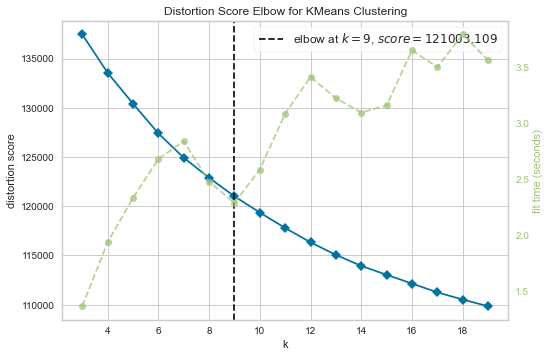

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
# Utilizaremos el método del codo para seleccionar el número de clusters
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20))

visualizer.fit(genome_scores_train_cluster.drop(['movieId', 'anio_movie'], axis=1)) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

In [14]:
# Obtenemos los 9 clusters
kmeans = KMeans(n_clusters=9, random_state=0).fit(genome_scores_train_cluster.drop(['movieId', 'anio_movie'], axis=1))

In [16]:
# Guardar el modelo
pickle.dump(kmeans, open("kmeans.pkl", "wb"))

In [17]:
# Obtenemos las etiquetas (clusters) de las películas con las que se obtuvieron los clusters
genome_scores_movie = genome_scores_train_cluster[['movieId']]
genome_scores_movie['label'] = kmeans.labels_
genome_scores_movie

/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_3617/1522655938.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genome_scores_movie['label'] = kmeans.labels_


,movieId,label
0,1,3
1,2,6
2,3,8
3,4,3
4,5,3
...,...,...
10026,108795,8
10072,110445,2
10090,110781,8
10191,114082,2


In [18]:
genome_scores_movie.label.value_counts(normalize=True)

1    0.204161
8    0.202697
3    0.126908
5    0.093874
0    0.092620
2    0.082375
6    0.069308
7    0.068890
4    0.059168
Name: label, dtype: float64

In [19]:
# Prediciendo el cluster de las películas que no entraron al entrenamiento
genome_scores_fuera_cluster = genome_scores.loc[(genome_scores['anio_movie'] > 2011) | (genome_scores['anio_movie'].isnull())]
print(genome_scores_fuera_cluster.shape)

genome_scores_movie_aux = genome_scores_fuera_cluster[['movieId']]
genome_scores_movie_aux['label'] = kmeans.predict(genome_scores_fuera_cluster.drop(['movieId', 'anio_movie'], axis=1))
genome_scores_movie_aux

(815, 1130)


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_3617/315561702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genome_scores_movie_aux['label'] = kmeans.predict(genome_scores_fuera_cluster.drop(['movieId', 'anio_movie'], axis=1))


,movieId,label
7593,40697,2
9406,89745,6
9476,91483,8
9477,91485,6
9478,91500,6
9479,91529,2
9480,91535,6
9493,91842,4
9496,91974,6
9497,91976,4


In [20]:
# Uniendo el total de películas taggeadas
genome_scores_movie = pd.concat([genome_scores_movie, genome_scores_movie_aux], axis=0)
genome_scores_movie

,movieId,label
0,1,3
1,2,6
2,3,8
3,4,3
4,5,3
...,...,...
10376,130578,8
10377,130840,1
10378,131013,8
10379,131168,0


In [21]:
genome_scores_movie.loc[genome_scores_movie['label'].isnull()]

,movieId,label


In [22]:
# Revisando las películas que están en cada cluster
genome_scores_movie_aux = pd.merge(
    genome_scores_movie,
    movie[['movieId', 'title', 'genres']],
    on = 'movieId',
    how = 'left'
    )
genome_scores_movie_aux

,movieId,label,title,genres
0,1,3,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,6,Jumanji (1995),Adventure|Children|Fantasy
2,3,8,Grumpier Old Men (1995),Comedy|Romance
3,4,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,3,Father of the Bride Part II (1995),Comedy
...,...,...,...,...
10376,130578,8,The Gunman (2015),Action|Thriller
10377,130840,1,Spring (2015),Horror|Romance|Sci-Fi
10378,131013,8,Get Hard (2015),Comedy
10379,131168,0,Phoenix (2014),Drama


In [25]:
genome_scores_movie_aux.loc[genome_scores_movie_aux['label'] ==0]

,movieId,label,title,genres
13,14,0,Nixon (1995),Drama
35,36,0,Dead Man Walking (1995),Crime|Drama
40,41,0,Richard III (1995),Drama|War
42,43,0,Restoration (1995),Drama
56,58,0,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance
71,73,0,"Misérables, Les (1995)",Drama|War
106,110,0,Braveheart (1995),Action|Drama|War
111,116,0,Anne Frank Remembered (1995),Documentary
137,150,0,Apollo 13 (1995),Adventure|Drama|IMAX
138,151,0,Rob Roy (1995),Action|Drama|Romance|War


In [26]:
# Preparando para crear variables
genome_label = genome_scores_movie.copy()
genome_label['label'] = 'label'+ genome_label['label'].astype(str)
genome_label['uno'] = 1
genome_label = genome_label.pivot(index = 'movieId', columns = 'label', values = 'uno').reset_index().fillna(0)
genome_label.head()

label,movieId,label0,label1,label2,label3,label4,label5,label6,label7,label8
0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Cruzando con el archivo rating
rating = pd.read_csv(os.path.join(mainpath,'rating.csv'))
rating['timestamp'] = pd.to_datetime(rating['timestamp'])

genome_label = pd.merge(
    rating,
    genome_label,
    on = 'movieId',
    how = 'left'
    )

del(rating)
genome_label

,userId,movieId,rating,timestamp,label0,label1,label2,label3,label4,label5,label6,label7,label8
0,1,2,3.5,2005-04-02 23:53:47,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,29,3.5,2005-04-02 23:31:16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,32,3.5,2005-04-02 23:33:39,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,47,3.5,2005-04-02 23:32:07,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,50,3.5,2005-04-02 23:29:40,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20000259,138493,69526,4.5,2009-12-03 18:31:48,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20000260,138493,69644,3.0,2009-12-07 18:10:57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20000261,138493,70286,5.0,2009-11-13 15:42:24,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Ordenando por userId y timestamp
genome_label = genome_label.sort_values(by=['userId', 'timestamp']).set_index('timestamp')
genome_label

,userId,movieId,rating,label0,label1,label2,label3,label4,label5,label6,label7,label8
timestamp,,,,,,,,,,,,
2004-09-10 03:06:38,1,924,3.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2004-09-10 03:07:01,1,919,3.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2004-09-10 03:07:30,1,2683,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-09-10 03:07:36,1,1584,3.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2004-09-10 03:07:45,1,1079,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-07 18:18:28,138493,6534,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2009-12-07 18:18:40,138493,53464,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2010-01-01 20:42:32,138493,1275,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
genome_label.columns

Index(['userId', 'movieId', 'rating', 'label0', 'label1', 'label2', 'label3',
       'label4', 'label5', 'label6', 'label7', 'label8'],
      dtype='object')

In [30]:
# cluster_ventana_tot: Número de películas que el usuario ha rankeado de ese cluster en cada ventana de tiempo.
# cluster_ventana_rat_prom: Promedio del rating que ha dado el usuario a películas de ese cluster para 
#                           cada ventana de tiempo.
# cluster_ventana_porc: Número de películas que el usuario ha rankeado de ese cluster entre el número total 
#                       de películas que ha rankeado para distintas ventavas de tiempo.


cols_label = ['label0', 'label1', 'label2', 'label3',
       'label4', 'label5', 'label6', 'label7', 'label8']

ventanas = ['7300d','365d', '90d', '30d', '7d']

for label in cols_label:
    aux = genome_label[['userId', 'movieId', 'rating', label]]
    aux['rating'] = aux['rating']*aux[label]
    
    for ventana in ventanas:
    
        tabla_varset4 = pd.merge(
            (aux.groupby('userId').rolling(ventana, min_periods=1)[label].sum()-aux.groupby('userId').rolling('1d', min_periods=1)[label].sum()).reset_index().drop_duplicates(subset=['userId', 'timestamp']).rename(columns = {
            label:label + ventana + '_tot'}),
            (aux.groupby('userId').rolling(ventana, min_periods=1).rating.sum()-aux.groupby('userId').rolling('1d', min_periods=1).rating.sum()).reset_index().drop_duplicates(subset=['userId', 'timestamp']).rename(columns = {
            'rating':label + ventana + '_rat_prom'}),
            on = ['userId', 'timestamp'],
            how = 'left'
        )
        tabla_varset4[label + ventana + '_rat_prom'] = tabla_varset4[label + ventana + '_rat_prom']/tabla_varset4[label + ventana + '_tot']
        filename = 'varset4_' + label + ventana + '.csv'
        tabla_varset4.to_csv(filename, index = False, quoting = 1, encoding = 'utf-8')
        print(ventana)
    print(label)
    
# Falta hacer: cluster_ventana_porc = cluster_ventana_tot/num_movies_ventana

/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_3617/255688499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[label]


7300d
365d
90d
30d
7d
label0


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_3617/255688499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[label]


7300d
365d
90d
30d
7d
label1


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_3617/255688499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[label]


7300d
365d
90d
30d
7d
label2


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_3617/255688499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[label]


7300d
365d
90d
30d
7d
label3


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_3617/255688499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[label]


7300d
365d
90d
30d
7d
label4


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_3617/255688499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[label]


7300d
365d
90d
30d
7d
label5


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_3617/255688499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[label]


7300d
365d
90d
30d
7d
label6


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_3617/255688499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[label]


7300d
365d
90d
30d
7d
label7


/var/folders/w_/3hgwjxr90d99fzgy06yhw4m00000gn/T/ipykernel_3617/255688499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['rating'] = aux['rating']*aux[label]


7300d
365d
90d
30d
7d
label8
